In [1]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import generate_expected_limits

In [2]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [3]:
names = ['flare0_informed',]
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    count = 0
    for combo in itertools.product(*priors[name]['hyperparams'].values()):
        if count == priors[name]['which_grid_point']:
            hyperparams_point = {}
            for i, key in enumerate(priors[name]['hyperparams'].keys()):
                hyperparams_point[key]=combo[i]
        count +=1
        
    priors[name]['net_path'] = (priors[name]['results_path'] + '/train_output/net/trained_network_round_'
                                +str(priors[name]['which_truncation'])+'_gridpoint_'+str(priors[name]['which_grid_point'])+'.pt')

    priors[name]['net'] = network.NetworkCorner(nbins=priors[name]['A'].nbins, marginals=priors[name]['POI_indices'], 
                                                param_names=priors[name]['A'].param_names, **hyperparams_point)

    priors[name]['net'].load_state_dict(torch.load(priors[name]['net_path']))

    with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
        priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name'])
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples'] = store.get_sample_store()
    priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
 
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 64,logger=False,)

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gertwk/.conda/envs/swyft4-dev-notebook/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')

In [8]:
def convert_pair_to_index(pair,n_indices):
    pair = sorted(pair)
    return int((pair[0]+1)*(n_indices-1+n_indices-pair[0]-1)/2 - n_indices + pair[1])

In [12]:
try:
    del sys.modules['DRP_test']
except KeyError:
    pass
from DRP_test import get_drp_coverage, draw_DRP_samples_fast

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

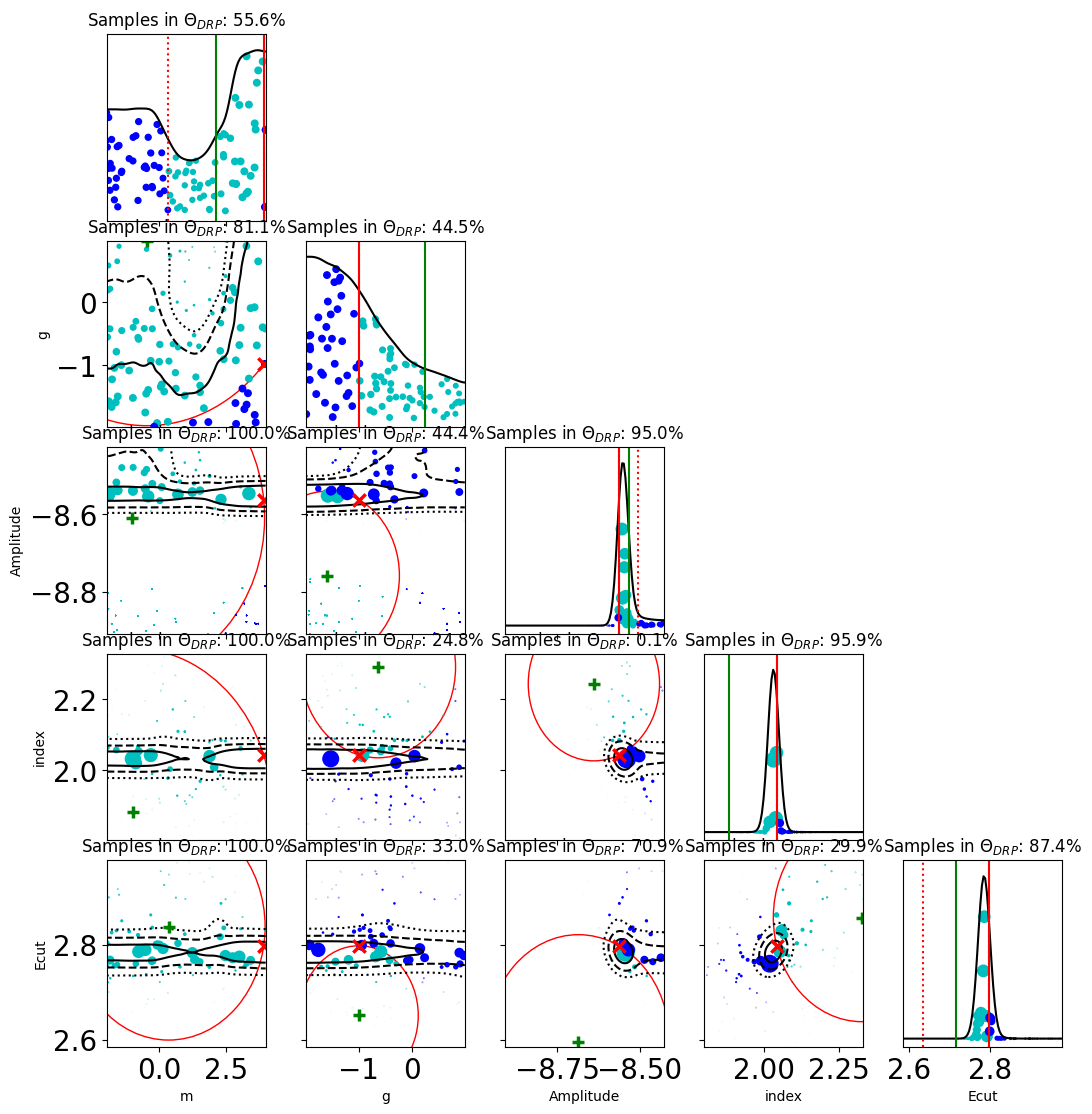

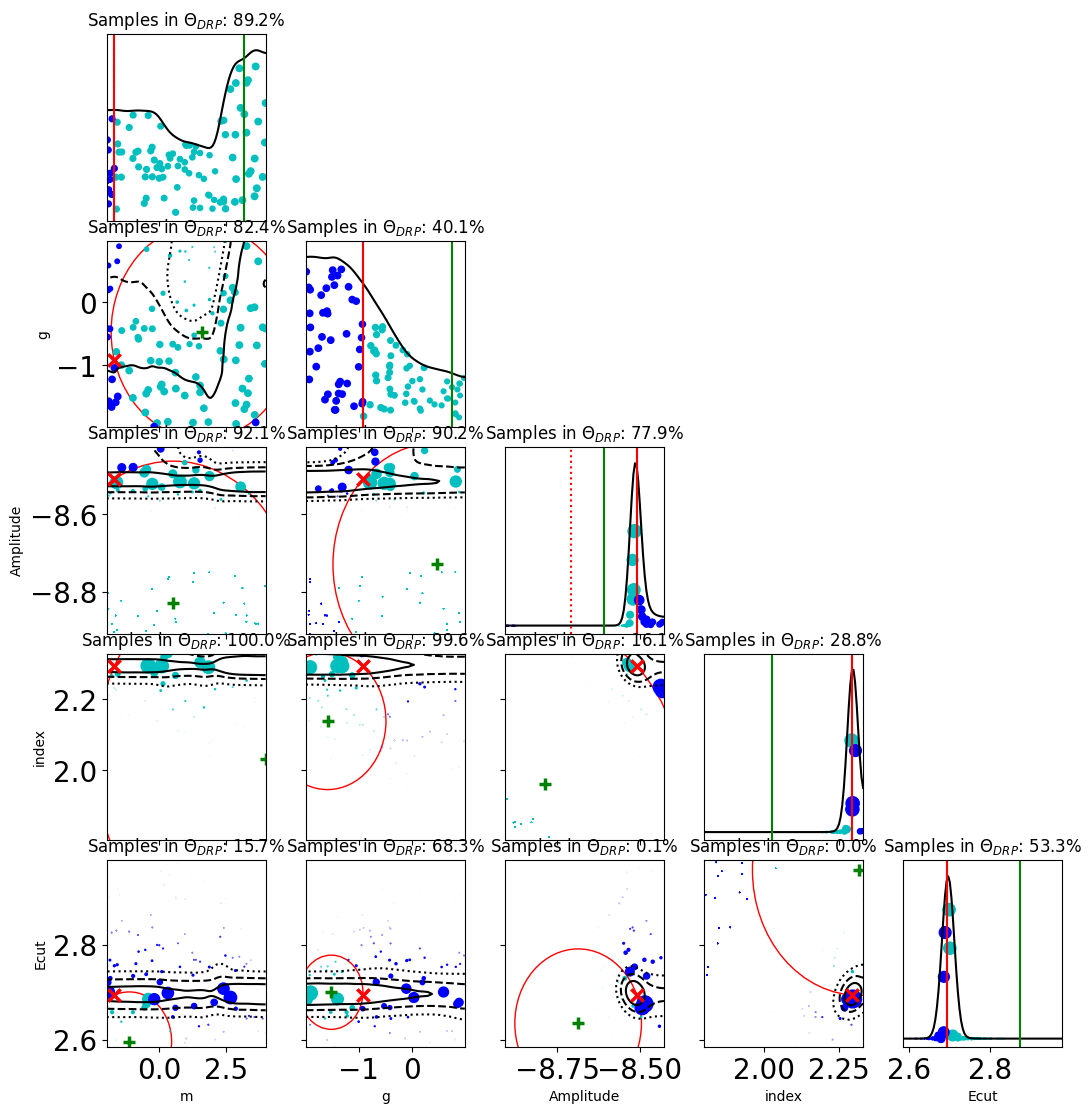

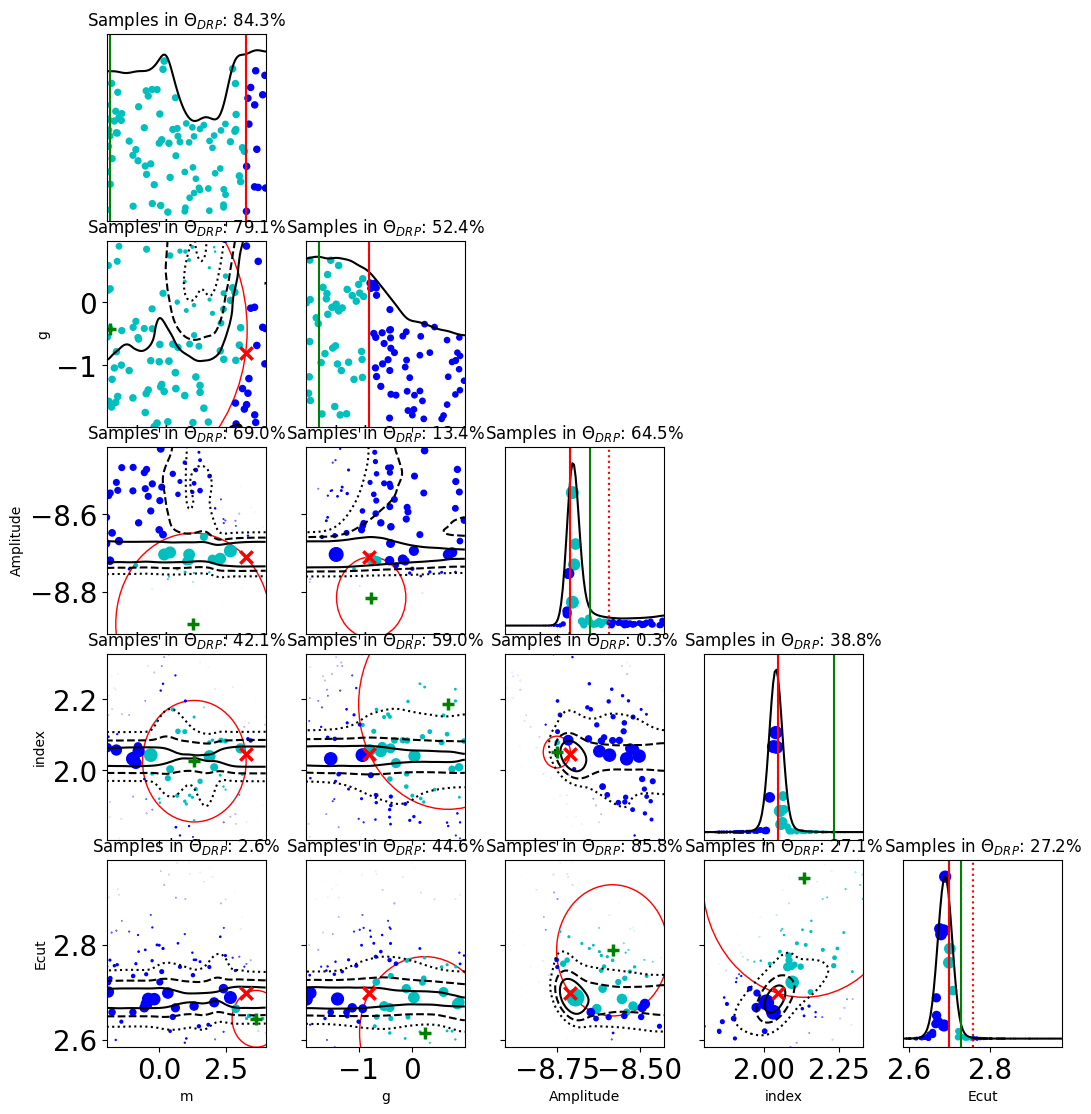

In [14]:
name = names[0]
n_samps = 3
n_prior_samps=100
n_hist_samps = 400_000
prior_samples = priors[name]['samples_prior']
which_truncation = priors[name]['which_truncation']
which_grid_point = priors[name]['which_grid_point']
bounds = np.array(priors[name]['bounds_rounds'][which_grid_point][which_truncation])

draws1d,draws2d,weights1d,weights2d = draw_DRP_samples_fast(
    priors[name]['net'],
    trainer,
    priors[name]['samples'][-n_samps:],
    priors[name]['samples_prior'][:n_prior_samps],
)


for j in range(n_samps):

    logratios = trainer.infer(
                    priors[name]['net'],
                    priors[name]['samples'][-n_samps:][j],
                    prior_samples,
    )

    fig = swyft.plot_corner(logratios, 
                      np.array(priors[name]['A'].param_names)[priors[name]['POI_indices']], 
                      # truth={priors[name]['A'].param_names[i]:sample['params'][i] for i in priors[name]['POI_indices']},
                      color_truth='r',
                      smooth=3,
                      figsize=(11,11),
                        contours_1d=False,
                        imshow=False,
                     )

    for i,poi in enumerate(priors[name]['POI_indices']):
        drp_samples = draws1d[logratios[0].parnames[poi][0]][:,[j],:]
        truth = priors[name]['samples'][-n_samps:]['params'][[j]][:,[poi]]
        weights = weights1d[logratios[0].parnames[poi][0]][:,[j]]
        
        get_drp_coverage(
            drp_samples,
            truth,
            references = "random",
            weights = weights,
            bounds=bounds[[poi]],
            theta_names=[],
            axes = [fig.axes[i*6]],
            maxy=np.max(np.array(fig.axes[i*6].lines[0].get_ydata())),
        )


    row = 0
    column = 0
    while row < len(priors[name]['POI_indices'])-1 or column < len(priors[name]['POI_indices'])-2:
            row+=1
            if row >= len(priors[name]['POI_indices']):
                column+=1
                row = 1+column
            axis_index = len(priors[name]['POI_indices'])*row+column
            logratios_index = convert_pair_to_index((column,row),len(priors[name]['POI_indices']))
        
            drp_samples = draws2d[str(logratios[1].parnames[logratios_index])][:,[j],:]
            truth = priors[name]['samples'][-n_samps:]['params'][[j]][:,[column,row]]
            weights = weights2d[str(logratios[1].parnames[logratios_index])][:,[j]]
    
            get_drp_coverage(
                drp_samples,
                truth,
                references = "random",
                weights = weights,
                bounds=bounds[[column,row]],
                theta_names=[],
                axes = [fig.axes[axis_index]],
            )